В этом модуле мы построим классификатор, который позволит своевременно определять уходящих клиентов банка.

In [1]:
import numpy as np #для матричных вычислений
import pandas as pd #для анализа и предобработки данных
import matplotlib.pyplot as plt #для визуализации
import seaborn as sns #для визуализации

from sklearn import linear_model #линейные модели
from sklearn import metrics #метрики
from sklearn.model_selection import train_test_split #разделение выборки
from sklearn import preprocessing #предобработка
%matplotlib inline
plt.style.use('seaborn')

C:\Users\lagovskiy.sergey\AppData\Local\Temp\1\ipykernel_20032\2408503256.py:11: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


In [2]:
churn_data = pd.read_csv('data/churn.zip')
churn_data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


RowNumber — номер строки таблицы;
CustomerId — идентификатор клиента;
Surname — фамилия клиента;
CreditScore — кредитный рейтинг клиента (чем он выше, тем больше клиент брал кредитов и возвращал их);
Geography — страна проживания клиента (банк межнациональный);
Gender — пол клиента;
Age — возраст клиента;
Tenure — сколько лет клиент пользуется банком;
Balance — сколько у клиента денег на счетах в банке;
NumOfProduct — число услуг банка, которые приобрёл клиент;
HasCrCard — есть ли у клиента кредитная карта (1 — да, 0 — нет);
IsActiveMember — есть ли у клиента статус активного участника банка (1 — да, 0 — нет);
EstimatedSalary — предполагаемая заработная плата клиента;
Exited — статус ушедшего (1 — ушедший клиент, 0 — лояльный клиент).

В модуле по визуализации мы выяснили, что отток клиентов в Германии, Франции и Испании имеет различные показатели. Исследователи, которые уже работали с этим датасетом, пришли к выводу, что наилучшее решение при работе с этими данными — строить модели индивидуально для каждой страны. Мы будем прогнозировать отток в немецком филиале банка. Давайте выделим только данные, относящиеся к Германии:

In [3]:
churn_data = churn_data[churn_data['Geography'] == 'Germany']
churn_data.shape

(2509, 14)

Сразу избавимся от заведомо неинформативных признаков: страна, номер строки, идентификатор пользователя и имя клиента.

In [4]:
churn_data = churn_data.drop(['Geography', 'RowNumber', 'CustomerId', 'Surname'], axis=1)
churn_data.head()

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
7,376,Female,29,4,115046.74,4,1,0,119346.88,1
15,616,Male,45,3,143129.41,2,0,1,64327.26,0
16,653,Male,58,1,132602.88,1,1,0,5097.67,1
26,756,Male,36,2,136815.64,1,1,1,170041.95,0
28,574,Female,43,3,141349.43,1,1,1,100187.43,0


In [5]:
churn_data.isnull().sum()

CreditScore        0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

Давайте расширим наш датасет с помощью методов Feature Engineering. Создадим следующие признаки:

BalanceSalaryRatio — отношение баланса на счетах к заработной плате клиента;
TenureByAge — отношение времени пользования банком к возрасту клиента;
CreditScoreGivenAge — отношение кредитного рейтинга к возрасту клиента.

In [6]:
churn_data['BalanceSalaryRatio'] = churn_data['Balance']/churn_data['EstimatedSalary']
churn_data['TenureByAge'] = churn_data['Tenure']/(churn_data['Age'])
churn_data['CreditScoreGivenAge'] = churn_data['CreditScore']/(churn_data['Age'])

Также перекодируем единственный текстовый категориальный признак Gender в бинарный столбец (1 — 'Male', 0 — 'Female'):

In [7]:
churn_data['Gender'] = churn_data['Gender'].apply(lambda x: 1 if x=='Male' else 0)
churn_data.head()

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,BalanceSalaryRatio,TenureByAge,CreditScoreGivenAge
7,376,0,29,4,115046.74,4,1,0,119346.88,1,0.963969,0.137931,12.965517
15,616,1,45,3,143129.41,2,0,1,64327.26,0,2.225020,0.066667,13.688889
16,653,1,58,1,132602.88,1,1,0,5097.67,1,26.012449,0.017241,11.258621
26,756,1,36,2,136815.64,1,1,1,170041.95,0,0.804599,0.055556,21.000000
28,574,0,43,3,141349.43,1,1,1,100187.43,0,1.410850,0.069767,13.348837


Разделим набор данных на матрицу наблюдений X и столбец ответов y:

In [8]:
X = churn_data.drop("Exited", axis=1)
y = churn_data["Exited"]

И, наконец, заранее позаботимся о масштабах признаков. Проведём нормализацию матрицы наблюдений X:

In [9]:
scaler = preprocessing.MinMaxScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)

Прежде чем перейти к этапу разделения выборки на тренировочную и тестовую, посмотрим на сбалансированность данных. Для этого воспользуемся методом value_counts() и выведем количество наблюдений каждого из классов в долевом соотношении от общего количества наблюдений:

In [10]:
y.value_counts(normalize=True)

0    0.675568
1    0.324432
Name: Exited, dtype: float64

Очевидно, что наши классы не сбалансированы. Ушедших пользователей — 32 %, в то время как лояльных — 68 %.

При разделении нашего набора данных на тренировочный и тестовый может возникнуть такая ситуация, что в тренировочную выборку попадут только лояльные клиенты или их большая часть. Тогда модель может не научиться определять вероятность оттока и качество на тестовой выборке будет оставлять желать лучшего.

Или противоположная ситуация: в тестовую выборку попадут только лояльные клиенты. Тогда модель будет показывать прекрасное качество на тестовой выборке, но в реальных условиях она может оказаться бесполезной.

То есть нам нужно сделать так, чтобы в тренировочной и тестовой выборках было одинаковое соотношение лояльных и ушедших клиентов. Такое разбиение выборки называется стратифицированным.

Как хорошо, что функция train_test_split() из библиотеки sklearn умеет производить такое разбиение! Для этого в функции предусмотрен параметр stratify, который нужно выставить в значение признака. Признак должен иметь одинаковые соотношения в тренировочной и тестовой выборках. У нас этим признаком является целевой признак y.

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, stratify=y, random_state=0)

print('Train shape: {}'.format(X_train.shape))
print('Test shape: {}'.format(X_test.shape))

Train shape: (1881, 12)
Test shape: (628, 12)


In [12]:
print('Train :', y_train.value_counts(normalize=True))
print('\n')
print('Test :', y_test.value_counts(normalize=True))

Train : 0    0.675704
1    0.324296
Name: Exited, dtype: float64


Test : 0    0.675159
1    0.324841
Name: Exited, dtype: float64


Обучите модель логистической регрессии на тренировочных данных. Используйте в качестве алгоритма минимизации функции потерь (параметр solver) стохастический градиентный спуск. В качестве значения параметра random_state возьмите 42 для воспроизводимости результатов. Остальные параметры оставьте по умолчанию.

Предскажите метки классов для тренировочной и тестовой выборок.

Чему равно значение целевой метрики на тренировочной и тестовой выборках? Ответ приведите с точностью до двух знаков после точки-разделителя.

In [13]:
log_reg = linear_model.LogisticRegression(solver='sag', random_state=42)
log_reg.fit(X_train, y_train)

y_train_pred = log_reg.predict(X_train)
print('Train F1: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
y_test_pred = log_reg.predict(X_test)
print('Test F1: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

Train F1: 0.49
Test F1: 0.47


Сгенерируйте полиномиальные признаки степени 3 для тренировочной и тестовой выборок. Используйте класс PolynomialFeatures из библиотеки sklearn. Параметр include_bias выставите в значение False.

Чему равно количество признаков в тренировочной выборке?

In [14]:
poly = preprocessing.PolynomialFeatures(degree=3, include_bias=False)

poly.fit(X_train)
X_train_poly = poly.transform(X_train)
X_test_poly = poly.transform(X_test)

print(X_train_poly.shape)

(1881, 454)


Обучите модель логистической регрессии на полиномиальных признаках.

Используйте в качестве алгоритма минимизации функции потерь (параметр solver) стохастический градиентный спуск. Параметру random_state выставите значение 42 для воспроизводимости результатов. Увеличьте максимальное количество итераций, выделяемых на сходимость (параметр max_iter), до 1000.

Остальные параметры оставьте по умолчанию.

Предскажите метки классов для тренировочной и тестовой выборок.

Чему равно значение целевой метрики на тренировочной и тестовой выборках для модели, обученной на полиномиальных признаках? Ответ приведите с точностью до двух знаков после точки-разделителя.

In [15]:
log_reg_poly = linear_model.LogisticRegression(solver='sag', max_iter=1000, random_state=42)

log_reg_poly.fit(X_train_poly, y_train)

y_train_pred_poly = log_reg_poly.predict(X_train_poly)
print('Train F1: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred_poly)))

y_test_pred_poly = log_reg_poly.predict(X_test_poly)
print('Test F1: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred_poly)))

Train F1: 0.66
Test F1: 0.64


Попробуйте подобрать значение порога вероятности, при котором наблюдается наибольшее значение целевой метрики на тестовой выборке. Используйте логистическую регрессию, обученную на полиномиальных признаках из предыдущего задания.

В качестве порога вероятности используйте значения из следующего диапазона:

thresholds = np.arange(0.1, 1, 0.05)
Напомним алгоритм, как определить оптимальный порог вероятности:

Предсказать вероятности оттока для каждого клиента из тестовой выборки.
В цикле перебирать значения порогов вероятности threshold: сделать предсказание класса по принципу: если вероятность > threshold, то отнести объект к классу 1, в противном случае — к классу 0. Далее рассчитать метрику и занести её в заранее созданный список.
Постройте график зависимости целевой метрики от порога вероятности.

Какому порогу вероятности соответствует наибольшее значение целевой метрики? Ответ приведите с точностью до двух знаков после точки-разделителя.

Text(0, 0.5, 'Score')

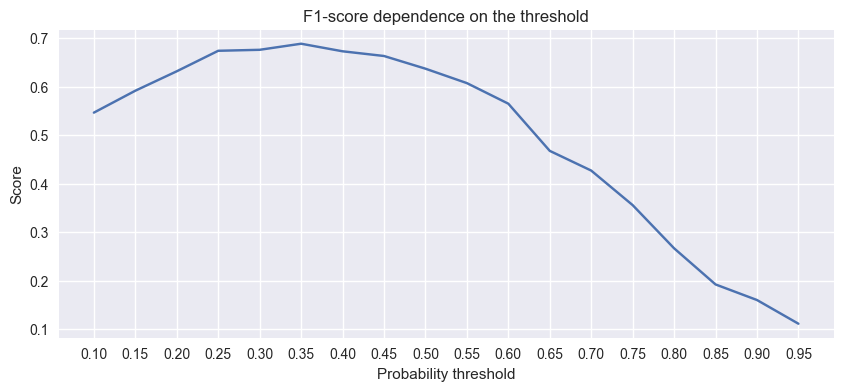

In [16]:
y_test_proba_pred = pd.Series(log_reg_poly.predict_proba(X_test_poly)[:, 1])
f1_scores = []
thresholds = np.arange(0.1, 1, 0.05)
for threshold in thresholds:
    y_test_pred_poly = y_test_proba_pred.apply(lambda x: 1 if x > threshold else 0)
    f1_scores.append(metrics.f1_score(y_test, y_test_pred_poly))
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(thresholds, f1_scores, label='F1')
ax.set_title('F1-score dependence on the threshold')
ax.set_xticks(thresholds)
ax.set_xlabel('Probability threshold')
ax.set_ylabel('Score')

Сделайте предсказание классов с подобранным оптимальным порогом вероятности. Чему равно значение целевой метрики на тестовой выборке? Ответ приведите с точностью до двух знаков после точки-разделителя.

In [17]:
threshold_opt = 0.35
y_test_pred_opt = y_test_proba_pred.apply(lambda x: 1 if x > threshold_opt else 0)
print('Test F1: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred_opt)))

Test F1: 0.69


<hr>
<hr>
<hr>
<hr>
<hr>

ДЕРЕВЬЯ РЕШЕНИЙ В SKLEARN

In [19]:
diabetes_data = pd.read_csv('data/diabetes_cleaned.zip')
diabetes_data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,98.0,58.0,33.0,34.0,0.430,43,0
1,2,112.0,75.0,32.0,35.7,0.148,21,0
2,2,108.0,64.0,29.0,30.8,0.158,21,0
3,8,107.0,80.0,29.0,24.6,0.856,34,0
4,7,136.0,90.0,29.0,29.9,0.210,50,0


диаграмма рассеяния, разделённая по цвету целевой переменной, признаком наличия диабета (Outcome)

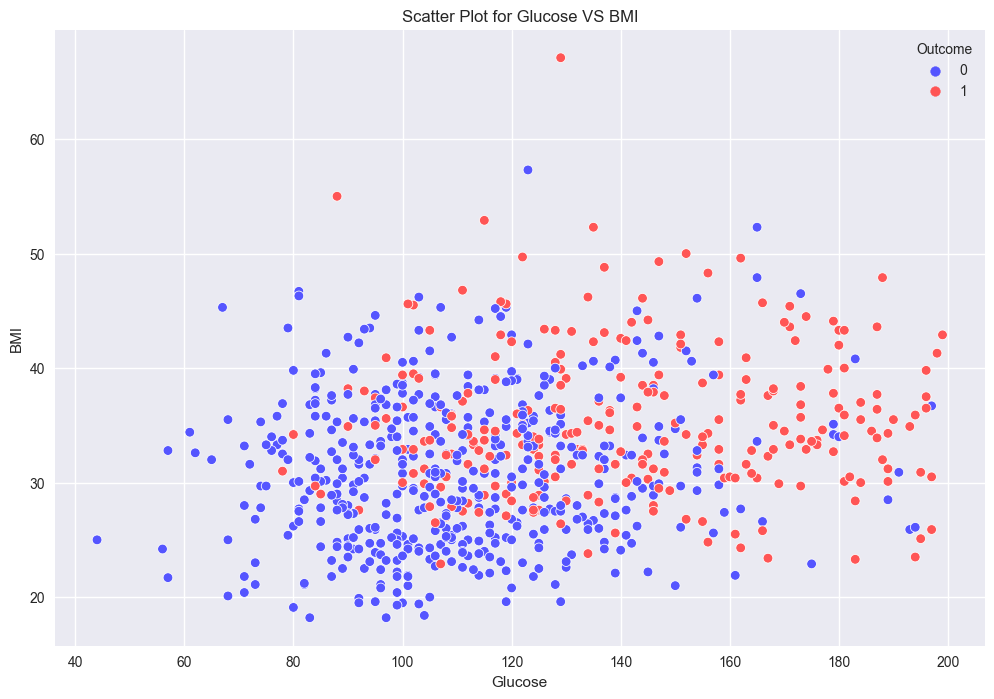

In [21]:
fig, ax = plt.subplots(figsize = (12, 8)) #фигура + координатная плоскость
#Строим диаграмму рассеяния
sns.scatterplot(
    data=diabetes_data, #датасет
    x='Glucose', #ось абсцисс
    y='BMI', #ось ординат
    hue='Outcome', #группировка
    palette='seismic', #палитра
    ax=ax, #координатная плоскость
);
#Задаём название графика
ax.set_title('Scatter Plot for Glucose VS BMI');

Создадим матрицу наблюдений X из признаков Glucose и BMI и столбец с правильными ответами y из признака Outcome

In [22]:
#Создаём матрицу наблюдений X и столбец с ответами y
X = diabetes_data[['Glucose', 'BMI']]
y = diabetes_data['Outcome']

Будем решать задачу классификации пациентов с помощью дерева решений.

Модель дерева решений, его модификаций, а также функции для работы с деревьями находятся в модуле tree библиотеки sklearn.

In [23]:
from sklearn import tree #модели деревьев решения

Давайте обучим дерево решений с критерием информативности criterion='entropy' (энтропия Шеннона), максимальной глубиной max_depth=3 и параметром random_state=42.

За обучение, как всегда, отвечает метод fit(). Данный метод реализует построение дерева решений по алгоритму CART, который мы рассматривали выше (алгоритм немного оптимизирован разработчиками sklearn, но смысл ровно тот же).

In [24]:
#Создаём объект класса DecisionTreeClassifier
dt_clf_2d = tree.DecisionTreeClassifier(
    criterion='entropy', #критерий информативности
    max_depth=3, #максимальная глубина
    random_state=42 #генератор случайных чисел
)
#Обучаем дерево решений по алгоритму CART
dt_clf_2d.fit(X, y)

DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=42)

Итак, мы обучили дерево решений. Обученное дерево можно визуализировать в виде графа, чтобы посмотреть, как дерево делает предсказание. Для этого есть функция plot_tree() из модуля tree.

Основные параметры функции:

decision_tree — объект обученного дерева решений,
feature_names — наименования факторов,
class_names — названия классов,
filled — добавлять ли расцветку вершин графа.

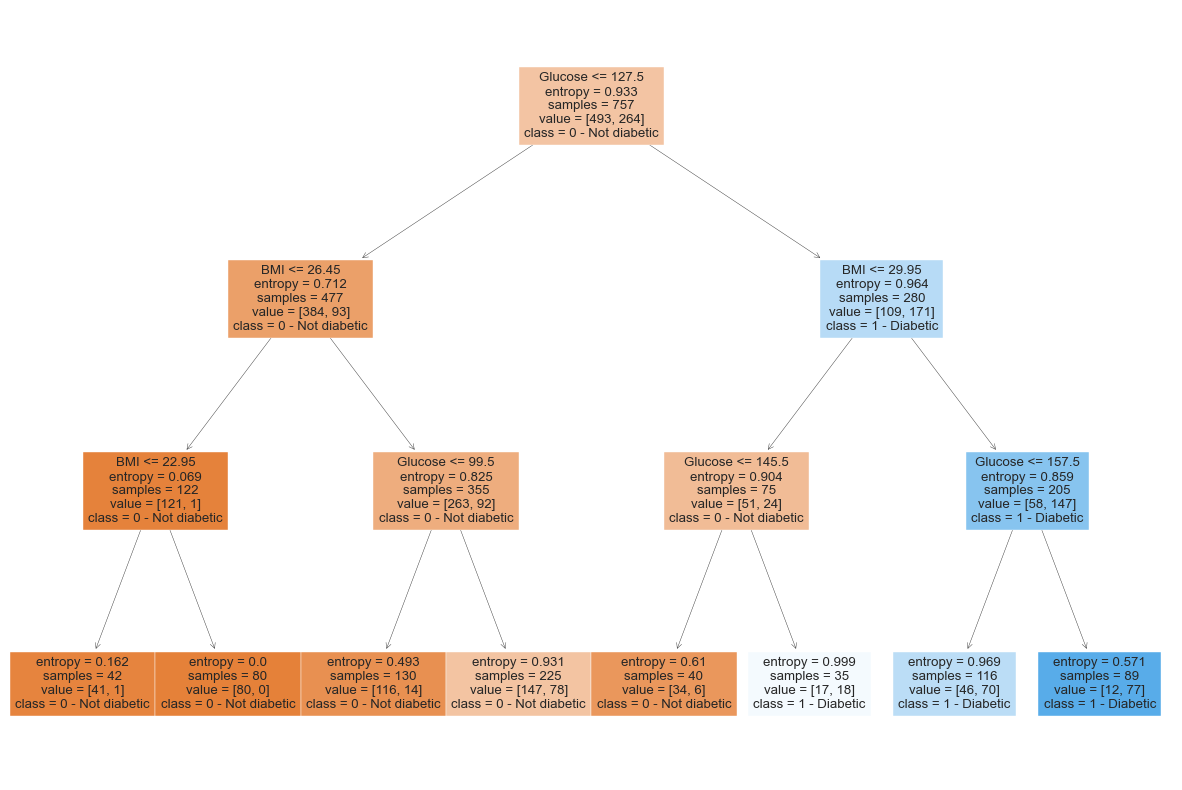

In [25]:
#Создаём фигуру для визуализации графа
fig = plt.figure(figsize=(15, 10))
#Строим граф дерева решений
tree.plot_tree(
    dt_clf_2d, #объект обученного дерева
    feature_names=X.columns, #наименования факторов
    class_names=["0 - Not diabetic", "1 - Diabetic"], #имена классов
    filled=True, #расцветка графа
);

В каждой из вершин записана следующая информация:

предикат, по которому происходит разбиение;
entropy — значение энтропии в текущей выборке;
samples — количество объектов;
values — количество объектов каждого из классов;
class — преобладающий класс, на основе которого будет сделано предсказание.

In [26]:
#Значения концентрации глюкозы и индекса массы тела для пациента
x_new = [[180, 51]]
#Делаем предсказание класса:
y_new_predict = dt_clf_2d.predict(x_new)
print('Predicted class: {}'.format(y_new_predict))
# Predicted class: [1]

Predicted class: [1]


d:\Work\DST\__environment\venv\lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


In [27]:
#Значения концентрации глюкозы и индекса массы тела для пациента
x_new = [[180, 51]]
#Делаем предсказание вероятностей:
y_new_proba_predict = dt_clf_2d.predict_proba(x_new)
print('Predicted probabilities: {}'.format(np.round(y_new_proba_predict, 3)))

# Predicted probabilities: [[0.135 0.865]]

Predicted probabilities: [[0.135 0.865]]


d:\Work\DST\__environment\venv\lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


Давайте посмотрим, как будет выглядеть разделяющая поверхность дерева решений для двух признаков. Для этого воспользуемся функцией plot_probabilities_2d()

In [28]:
def plot_probabilities_2d(X, y, model):
    #Генерируем координатную сетку из всех возможных значений для признаков
    #Glucose изменяется от 40 до 200, BMI — от 10 до 80
    #Результат работы функции — два массива xx1 и xx2, которые образуют координатную сетку
    xx1, xx2 = np.meshgrid(
        np.arange(40, 200, 0.1),
        np.arange(10, 80, 0.1)
    )
    #Вытягиваем каждый из массивов в вектор-столбец — reshape(-1, 1)
    #Объединяем два столбца в таблицу с помощью hstack
    X_net = np.hstack([xx1.reshape(-1, 1), xx2.reshape(-1, 1)])
    #Предсказываем вероятность для всех точек на координатной сетке
    #Нам нужна только вероятность класса 1
    probs = model.predict_proba(X_net)[:, 1]
    #Переводим столбец из вероятностей в размер координатной сетки
    probs = probs.reshape(xx1.shape)
    #Создаём фигуру и координатную плоскость
    fig, ax = plt.subplots(figsize = (10, 5))
    #Рисуем тепловую карту вероятностей
    contour = ax.contourf(xx1, xx2, probs, 100, cmap='bwr')
    #Рисуем разделяющую плоскость — линию, где вероятность равна 0.5
    bound = ax.contour(xx1, xx2, probs, [0.5], linewidths=2, colors='black');
    #Добавляем цветовую панель
    colorbar = fig.colorbar(contour)
    #Накладываем поверх тепловой карты диаграмму рассеяния
    sns.scatterplot(data=X, x='Glucose', y='BMI', hue=y, palette='seismic', ax=ax)
    #Даём графику название
    ax.set_title('Scatter Plot with Decision Boundary');
    #Смещаем легенду в верхний левый угол вне графика
    ax.legend(bbox_to_anchor=(-0.05, 1))

d:\Work\DST\__environment\venv\lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


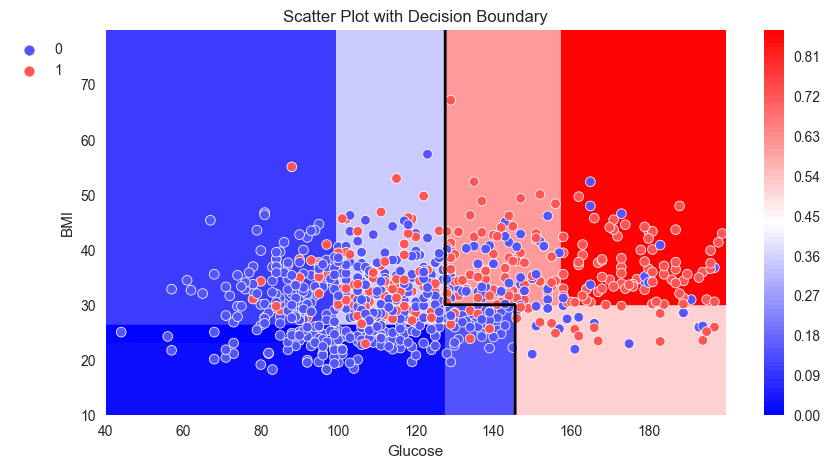

In [29]:
plot_probabilities_2d(X, y, dt_clf_2d)

Можно рассчитать полученные метрики качества. Для этого предскажем наличие диабета для всех пациентов из матрицы наблюдений X, а затем рассчитаем метрики классификации с помощью функции classification_report() из библиотеки sklearn

In [30]:
#Делаем предсказание класса для всего набора данных
y_pred = dt_clf_2d.predict(X)
#Выводим отчёт о метриках классификации
print(metrics.classification_report(y, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.85      0.83       493
           1       0.69      0.62      0.65       264

    accuracy                           0.77       757
   macro avg       0.75      0.74      0.74       757
weighted avg       0.77      0.77      0.77       757



In [31]:
#Создаём объект класса DecisionTreeClassifier
dt_clf_bad = tree.DecisionTreeClassifier(
    criterion='entropy', #критерий информативности
    random_state=42 #генератор случайных чисел
)
#Обучаем дерево решений по алгоритму CART без ограничения его длины
dt_clf_bad.fit(X, y)

DecisionTreeClassifier(criterion='entropy', random_state=42)

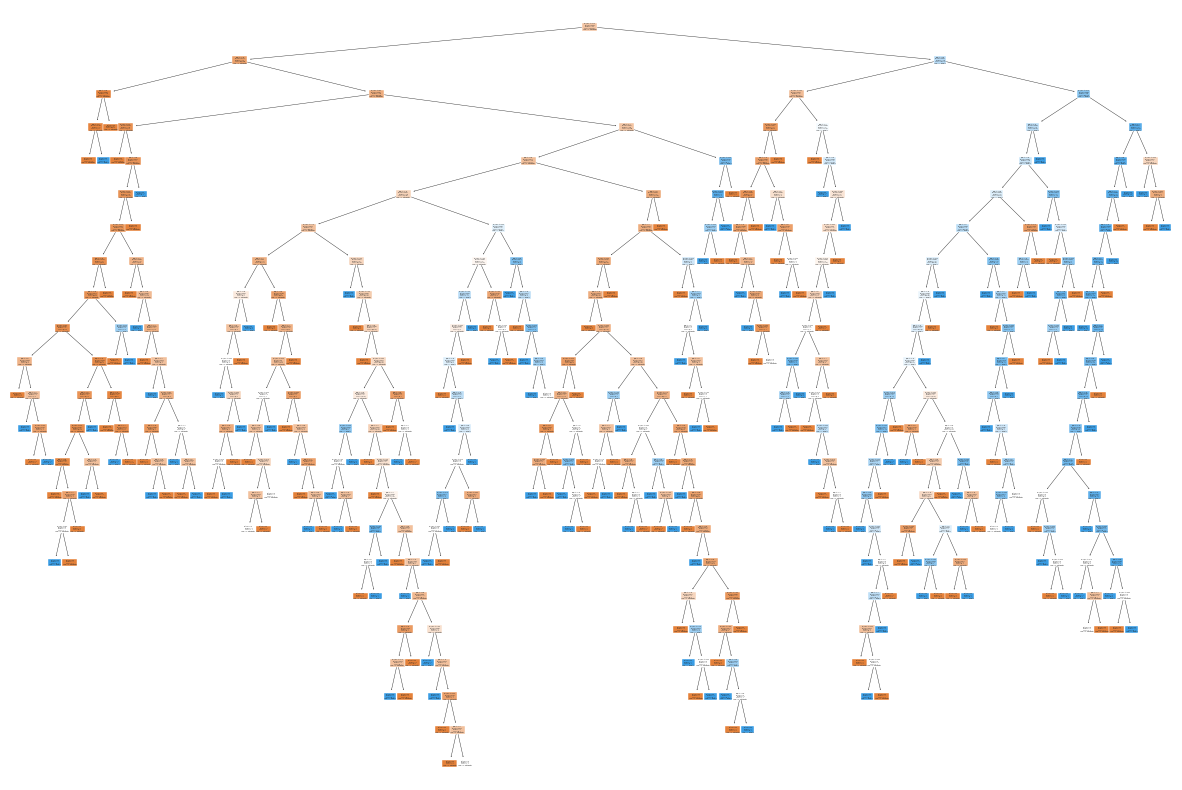

In [32]:
#Создаём фигуру для визуализации графа
fig = plt.figure(figsize=(15, 10))
#Строим граф дерева решений
tree.plot_tree(
    dt_clf_bad, #объект обученного дерева
    feature_names=X.columns, #наименования факторов
    class_names=["0 - Not diabetic", "1 - Diabetic"], #имена классов
    filled=True, #расцветка графа
);

d:\Work\DST\__environment\venv\lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


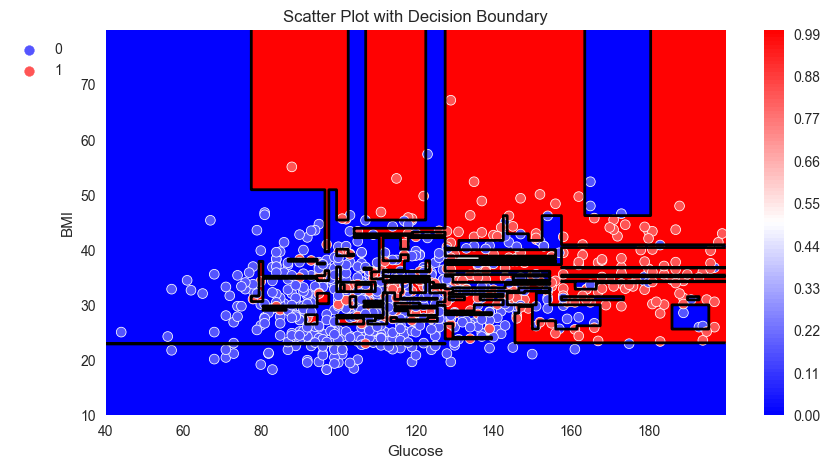

In [33]:
plot_probabilities_2d(X, y, dt_clf_bad)

In [34]:
#Делаем предсказание класса для всего набора данных
y_pred = dt_clf_bad.predict(X)
#Выводим отчёт о метриках классификации
print(metrics.classification_report(y, y_pred))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       493
           1       1.00      0.97      0.98       264

    accuracy                           0.99       757
   macro avg       0.99      0.98      0.99       757
weighted avg       0.99      0.99      0.99       757



In [35]:
#Создаём матрицу признаков X и столбец с ответами y
X = diabetes_data.drop('Outcome', axis=1)
y = diabetes_data['Outcome']

In [36]:
#Создаём объект класса DecisionTreeClassifier
dt_clf_full = tree.DecisionTreeClassifier(
    criterion='entropy', #критерий информативности
    max_depth=6, #максимальная глубина дерева
    random_state=42 #генератор случайных чисел
)
#Обучаем модель по алгоритму CART
dt_clf_full.fit(X, y)

DecisionTreeClassifier(criterion='entropy', max_depth=6, random_state=42)

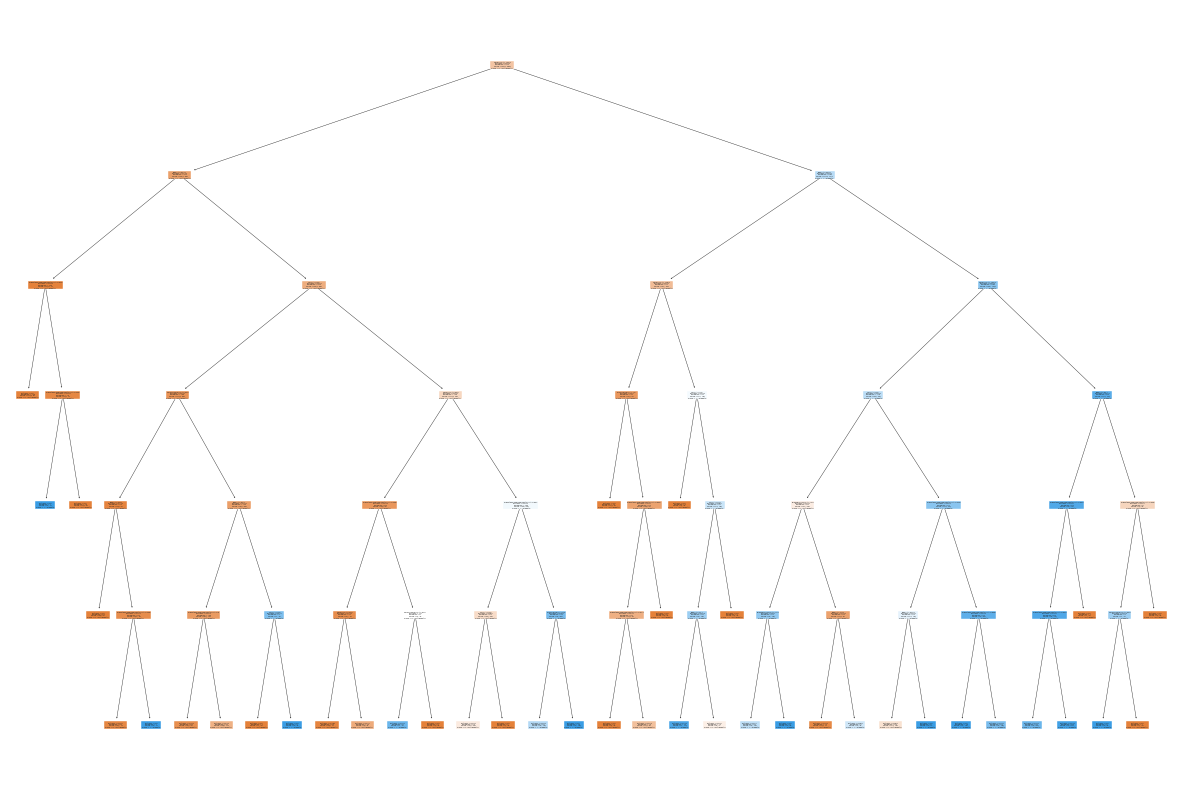

In [37]:
#Создаём фигуру для визуализации графа
fig = plt.figure(figsize=(15, 10))
#Строим граф дерева решений
tree.plot_tree(
    dt_clf_full, #объект обученного дерева
    feature_names=X.columns, #наименования факторов
    class_names=["0 - Not diabetic", "1 - Diabetic"], #имена классов
    filled=True, #расцветка графа
);

In [38]:
#Делаем предсказание класса
y_pred = dt_clf_full.predict(X)
#Выводим отчёт о метриках
print(metrics.classification_report(y, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.93      0.89       493
           1       0.84      0.69      0.76       264

    accuracy                           0.85       757
   macro avg       0.84      0.81      0.82       757
weighted avg       0.84      0.85      0.84       757



ерево решений позволяет определить важность признаков.

Важность признаков можно посмотреть, обратившись к атрибуту feature_importance_:

In [39]:
print(dt_clf_full.feature_importances_)

[0.02675774 0.36675873 0.03368236 0.04553664 0.24588118 0.14137465
 0.14000868]


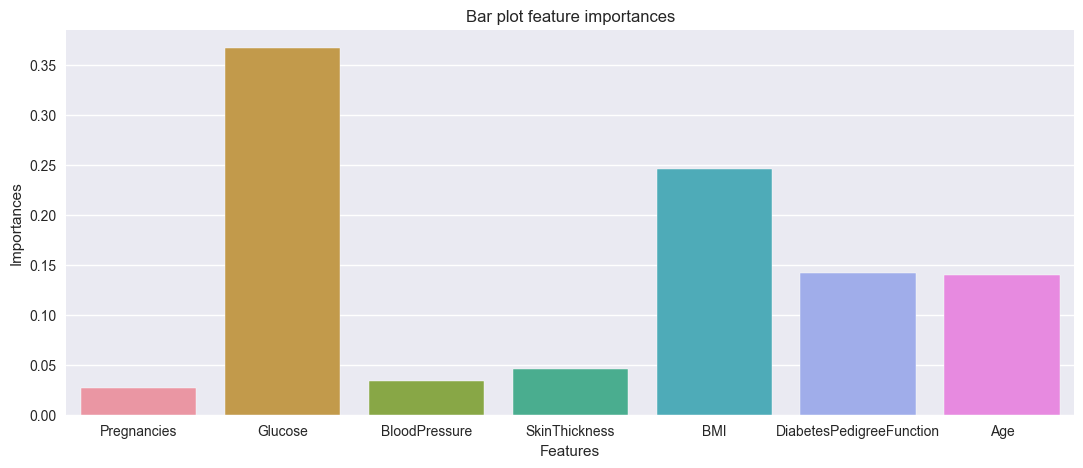

In [40]:
fig, ax = plt.subplots(figsize=(13, 5)) #фигура + координатная плоскость
feature = X.columns #признаки
feature_importances = dt_clf_full.feature_importances_ #важность признаков
#Строим столбчатую диаграмму
sns.barplot(x=feature, y=feature_importances, ax=ax);
#Добавляем подпись графику, осям абсцисс и ординат
ax.set_title('Bar plot feature importances')
ax.set_xlabel('Features')
ax.set_ylabel('Importances');

Для выполнения задания используйте датасет о диабете из данного модуля. Для обучения используйте все доступные признаки.

Обучите дерево решений с максимальной глубиной 6 и критерием информативности Джини. В качестве значения параметра random_state возьмите число 42.

Сделайте предсказание и рассчитайте F-меру.

Чему равно значение метрики? Ответ запишите с точностью до второго знака после точки-разделителя.

Пример ввода ответа: 0.12

In [41]:
#Создаём объект класса DecisionTreeClassifier
dt_clf_full = tree.DecisionTreeClassifier(
    criterion='gini', #критерий информативности
    max_depth=6, #максимальная глубина дерева
    random_state=42 #генератор случайных чисел
)
#Обучаем модель по алгоритму CART
dt_clf_full.fit(X, y)

#Делаем предсказание класса
y_pred = dt_clf_full.predict(X)
#Выводим отчёт о метриках
print(metrics.classification_report(y, y_pred))

              precision    recall  f1-score   support

           0       0.86      0.93      0.90       493
           1       0.85      0.73      0.78       264

    accuracy                           0.86       757
   macro avg       0.85      0.83      0.84       757
weighted avg       0.86      0.86      0.86       757



<hr><hr><hr><hr><hr>

Введение в ансамбли: бэггинг. Случайный лес